In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import math
import datetime as dt

In [2]:
# Load the CSV files into a list of DataFrames
data_dir = "data/keog/"

os.environ['OMP_NUM_THREADS'] = '1'

PRINT = False
SAVE = False
dataframes = []
dates = []

for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_dir, file))
        dataframes.append(df)

In [ ]:
heatmaps = []  
heatmaps_imputed = []  

imputer = SimpleImputer(strategy='mean')

for df in dataframes:
    XX, YY = np.meshgrid(df['time_seconds'].unique(), df['gdlat'].unique())
    ZZ = df['blrmvd'].values
    ZZ = np.reshape(ZZ, XX.T.shape).T

    heatmaps.append(ZZ)

    hmi = imputer.fit_transform(ZZ).flatten()
    if hmi.size == 1125:
        heatmaps_imputed.append(hmi)
        first_date = df['datetime'].iloc[0][:10]
        dates.append(first_date)
    else:
        continue

heatmaps_imputed = np.vstack(heatmaps_imputed)

c:\Users\Maria\anaconda3\envs\gradu\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [106]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\Maria\anaconda3\envs\gradu\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [59 60 61 62]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [4]:
num_clus = 4
kmeans = KMeans(n_clusters=num_clus)  
labels = kmeans.fit_predict(heatmaps_imputed)

if PRINT:
    for i in range(num_clus):
        cluster_indices = np.where(labels == i)[0]
        print(f"Cluster {i}:")
        for idx in cluster_indices:
            print(f" - Date: {dates[idx]}")

In [5]:
if PRINT:
    for i in range(num_clus):
        cluster_indices = np.where(labels == i)[0]
        n_images = len(cluster_indices)
        print(f"Cluster {i}: {n_images} heatmaps")

        # Setup subplot grid
        n_cols = 5
        n_rows = math.ceil(n_images / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
        axes = axes.flatten()  # Flatten for easy indexing

        for j, idx in enumerate(cluster_indices):
            ax = axes[j]
            ax.imshow(heatmaps[idx], aspect='auto', cmap='viridis')
            ax.set_title(f"Heatmap {idx}\n{dates[idx]}")
            ax.axis('off')  # Hide axes for cleaner layout

        # Hide unused subplots
        for k in range(j+1, len(axes)):
            axes[k].axis('off')

        fig.suptitle(f'Cluster {i}', fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for title
        plt.show()

In [6]:
if SAVE:
    data = {'dates': dates, 'labels':labels}
    datadf = pd.DataFrame(data, columns=['dates', 'labels'])
    datadf.to_csv(f'data/klusterit/klusteri{k}.csv')
    pd.DataFrame(dates, columns=['date']).to_csv('data/dates.csv', index=False)

if PRINT:
    print(dates)
    print(labels)

In [7]:
ks = [2,3,4,5,6,7,8,9,10,15,25,30]
clusters = {'dates':dates}
for k in ks:
    kmeans = KMeans(n_clusters=k) 
    labels = kmeans.fit_predict(heatmaps_imputed)
    clusters['k'+str(k)] = list(labels)

if SAVE:
    pd.DataFrame(clusters).to_csv('data/clusterdf.csv', index=False)


In [8]:
nruns = 100
jakaumat = {}


for k in ks:
    jakaumat[f'{k}'] = []
    for i in range(nruns):
        kmeans = KMeans(n_clusters=k) 
        labels = kmeans.fit_predict(heatmaps_imputed)
        jak = sorted([len(np.where(labels == j)[0]) for j in range(k)], reverse=True)
        jakaumat[f'{k}'].append(jak)


In [9]:
ykkosluvut = {}
muut = {}

for i in jakaumat:
    ykkosluvut[i] = []
    muut[i] = []
    for run in jakaumat[i]:
        indexit = np.where(np.array(run) == 1)[0]
        ykkosluvut[i].append(len(indexit))
        if len(indexit) > 0:
            muut[i].append(run[:indexit[0]])
        else:
            muut[i].append(run)


In [10]:
for i in ykkosluvut:
    print(i, np.average(ykkosluvut[i]), np.average(ykkosluvut[i])/int(i), sum(ykkosluvut[i]))

2 0.58 0.29 58
3 1.25 0.4166666666666667 125
4 1.98 0.495 198
5 2.55 0.51 255
6 3.28 0.5466666666666666 328
7 3.86 0.5514285714285714 386
8 4.85 0.60625 485
9 5.81 0.6455555555555555 581
10 6.29 0.629 629
15 10.31 0.6873333333333334 1031
25 19.76 0.7904000000000001 1976
30 24.11 0.8036666666666666 2411


In [11]:
maxit = {'1':[], '2':[], '3':[]}
ykone = {}

for key in muut:
    ykone[key] = []
    for vals in muut[key]:
        ykone[key].append(vals[0])
        for z in range(0,len(vals)):
            try:
                maxit[str(z+1)].append(vals[z])
            except:
                continue


In [12]:
np.average(maxit['1']), np.average(maxit['2']), np.average(maxit['3'])

(102.15916666666666, 22.96759259259259, 9.75)

In [13]:
np.std(maxit['1']), np.std(maxit['2']), np.std(maxit['3']) 

(20.4979795582936, 7.204927952240894, 6.421457704261475)

In [14]:
for kykoset in ykone:
    print(kykoset, np.average(ykone[kykoset]))

2 128.47
3 121.1
4 114.65
5 111.73
6 108.92
7 103.79
8 102.07
9 100.45
10 96.27
15 87.44
25 76.38
30 74.64


In [30]:
hairiot = [dt.date(2019, 2, 28),
 dt.date(2019, 6, 10),
 dt.date(2019, 6, 13),
 dt.date(2019, 7, 1),
 dt.date(2019, 8, 30),
 dt.date(2019, 9, 2),
 dt.date(2019, 10, 29),
 dt.date(2020, 9, 23),
 dt.date(2021, 1, 15),
 dt.date(2021, 11, 6),
 dt.date(2022, 1, 3),
 dt.date(2022, 1, 4),
 dt.date(2022, 3, 13),
 dt.date(2022, 3, 25),
 dt.date(2023, 2, 27)]



dates = [dt.datetime.strptime(d, "%Y-%m-%d").date() for d in dates]


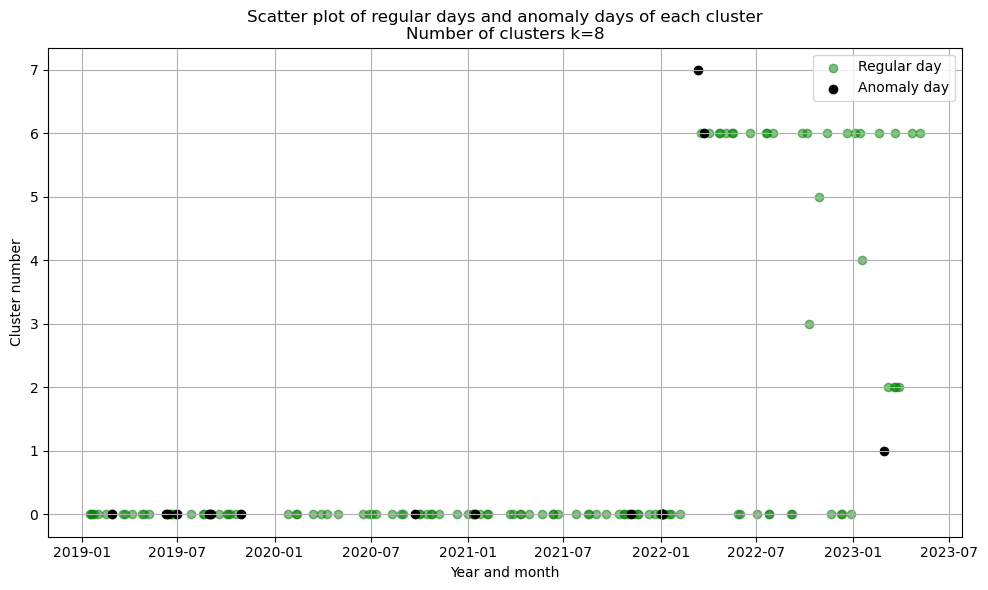

In [57]:
kmeans = KMeans(n_clusters=8)
labels = kmeans.fit_predict(heatmaps_imputed)

fig, ax = plt.subplots(figsize=(10, 6))


anomaly_indices = [i for i, d in enumerate(dates) if d in hairiot]
regular_indices = [i for i, d in enumerate(dates) if d not in hairiot]

ax.scatter(
    [dates[i] for i in regular_indices],
    [labels[i] for i in regular_indices],
    color='green',
    alpha=0.5,
    label='Regular day'
)

ax.scatter(
    [dates[i] for i in anomaly_indices],
    [labels[i] for i in anomaly_indices],
    color='black',
    alpha=1.0,
    label='Anomaly day'
)


ax.grid(True)
ax.legend()
ax.set_yticks(range(0, 8))
plt.title('Scatter plot of regular days and anomaly days of each cluster\nNumber of clusters k=8')
plt.ylabel('Cluster number')
plt.xlabel('Year and month')
plt.tight_layout()
plt.show()